In [90]:
%matplotlib inline
%pylab inline

import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

DEVICE = "cpu"
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    DEVICE = "cuda"
else:
    print("No GPU available!")

DEVICE

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


'cuda'

In [91]:
# Load the .npy file
# file_parent_path = "/content/drive/MyDrive/bda_assessment_data/"
file_parent_path = "/teamspace/studios/this_studio/"

train_data = np.load(f"{file_parent_path}Ferguson_fire_train.npy")
test_data = np.load(f"{file_parent_path}/Ferguson_fire_test.npy")

print("** (raw) DATA INFO **")
print(f"train: type={type(train_data)}, dims={train_data.shape}")
print(f"test: type={type(test_data)}, dims={test_data.shape}")

** (raw) DATA INFO **
train: type=<class 'numpy.ndarray'>, dims=(12500, 256, 256)
test: type=<class 'numpy.ndarray'>, dims=(5000, 256, 256)


In [92]:
def sequential_undersample_3d_arr(arr, sequence_jump, _print: bool = True):
    """
    test cases:
    arr = np.array([[[1, 2, 3]], [[-1, -2, -3]], [[4, 5, 6]], [[4, 5, 6]]])

    arr[0:15, :, :], arr[0:0, :, :], arr[0:2, :, :]

    """
    assert len(train_data.shape) == 3
    sequence_jump = max(1, sequence_jump)  # avoids error at 0.

    undersampled_arr = arr[0::sequence_jump, :, :]

    if _print:
        print("\n** (undersampled) data info **")
        print(f"X_train_undersampled: {undersampled_arr.shape}")

    return undersampled_arr


def sequential_train_val_split(
    train_data,
    sequence_jump: int,
    start_offset: int = 2,
    jump_multiplier: int = 3,
    _print: bool = True,
):
    """assumes item number / time is first dim then HxW.
    1 test: assert train_data.shape[0] == len(train_idx) + len(val_idx)
    """
    val_idx = []
    for i in range(
        (sequence_jump * start_offset) + 1,
        train_data.shape[0],
        sequence_jump * jump_multiplier,
    ):
        val_idx.append(i)

    train_idx = [i for i in range(train_data.shape[0]) if i not in val_idx]

    X_train = train_data[train_idx]
    X_val = train_data[val_idx]

    if _print:
        print(f"\n** (split) data info (w/ jump={sequence_jump})**")
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}")

    return X_train, X_val

In [93]:
# # ** undersampling timesteps **
# jump = 3
# print(f"\n ** Undersampling the training data @ {jump} intervals **\n")

# # train_data_us = train_data[0::jump, :, :]
# train_data_us = sequential_undersample_3d_arr(arr=train_data, sequence_jump=3)

# print("** (undersampled) data info **")
# print(f"train_data_us: {train_data_us.shape}")

In [94]:
train_data_us = sequential_undersample_3d_arr(arr=train_data, sequence_jump=1)

X_train, X_val = sequential_train_val_split(
    train_data=train_data_us, sequence_jump=3, start_offset=2, jump_multiplier=3
)


** (undersampled) data info **
X_train_undersampled: (12500, 256, 256)

** (split) data info (w/ jump=3)**
X_train: (11111, 256, 256)
X_val: (1389, 256, 256)


In [95]:
# # creating a validation dataset.
# val_idx = []
# val_jump = 3

# for i in range((val_jump * 2) + 1, train_data_us.shape[0], val_jump * 3):
#     val_idx.append(i)

# train_idx = [i for i in range(train_data_us.shape[0]) if i not in val_idx]

# assert train_data_us.shape[0] == len(train_idx) + len(val_idx)

# X_train2 = train_data_us[train_idx]
# X_val2 = train_data_us[val_idx]

# print(f"** (split) data info [jump={val_jump}]**")
# print(f"X_train: {X_train.shape}")
# print(f"X_val: {X_val.shape}")
# print(f"X_test: {test_data.shape}")

In [96]:
# create an image dataset that can be used for this data.
class WildfireImageDataSet(Dataset):
    def __init__(self, data, transform):
        """Initialisation."""
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        """Get raw data using idx and apply transforms to output a processed image tensor."""
        image = self.data[idx]  # .astype(np.float32)
        if self.transform:
            image = self.transform(image)

        assert isinstance(image, torch.Tensor)

        return image

    def __len__(self):
        return len(self.data)

In [97]:
transform = transforms.Compose(
    transforms=[
        transforms.ToTensor(),
    ]
)

train_dataset = WildfireImageDataSet(data=X_train, transform=transform)

val_dataset = WildfireImageDataSet(data=X_val, transform=transform)

test_dataset = WildfireImageDataSet(data=test_data, transform=transform)

Text(0.5, 1.0, 'torch data @ idx 3]')

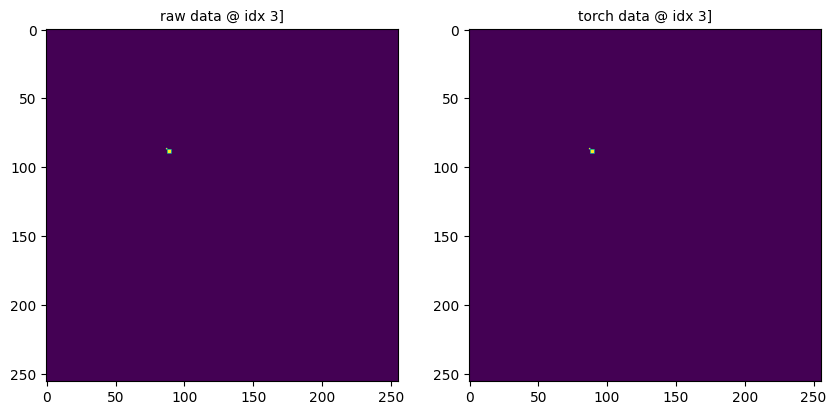

In [98]:
idx = 3
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axs[0].imshow(X_train[idx])
axs[1].imshow(train_dataset.__getitem__(idx).permute(1, 2, 0))

# train_img = train_dataset.__getitem__(idx).permute(1, 2, 0)
# train_img = (train_img + 1) / 2
# axs[1].imshow(train_img)

axs[0].set_title(f"raw data @ idx {idx}]", fontsize=10)
axs[1].set_title(f"torch data @ idx {idx}]", fontsize=10)

In [99]:
# KEY PARAMETERS for DATA
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [100]:
### Lets plot a batch from the train_loader:
train_batch = next(iter(train_loader)).float()
print(train_batch.shape)

torch.Size([32, 1, 256, 256])


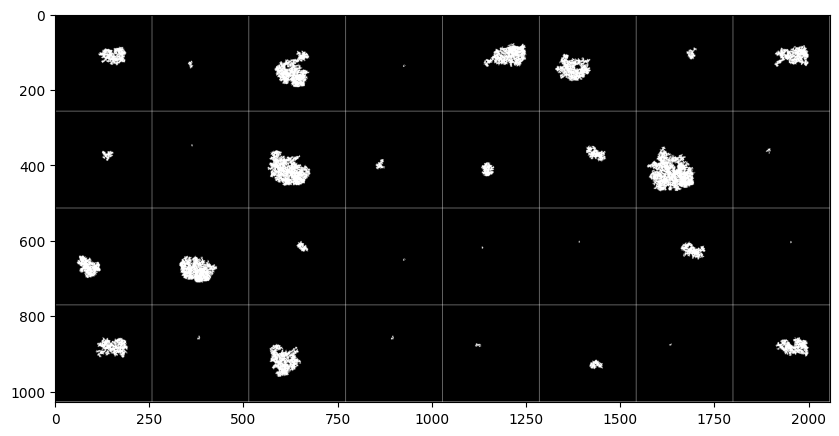

In [101]:
from torchvision.utils import make_grid

fig, ax = plt.subplots(figsize=(10, 10))
batch_grid = make_grid(train_batch[:batch_size], nrow=8, padding=1, pad_value=1.0)
ax.imshow(batch_grid[0], cmap="gray")

In [25]:
class FCVAE(nn.Module):
    def __init__(self, input_image_dims, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.input_image_dims = input_image_dims
        self.c, self.h, self.w = input_image_dims

        self.encode = nn.Sequential(
            nn.Linear(self.c * self.h * self.w, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self._mu = nn.Linear(128, self.latent_dims)
        self._logvar = nn.Linear(128, self.latent_dims)

        self.decode = nn.Sequential(
            nn.Linear(self.latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.c * self.h * self.w),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """Forward pass."""
        encoded = self.encode(x.flatten(start_dim=1))
        mu = self._mu(encoded)
        logvar = self._logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)

        return decoded.view(-1, self.c, self.h, self.w), mu, logvar


def vae_loss(x, recon_x, mu, logvar, beta):
    """Calculates VAE loss combining reconstruction loss and KL divergence."""
    mse_loss = F.mse_loss(x, recon_x, reduction="sum")  # can also try 'mean' and 'sum'
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return mse_loss, beta * kld_loss

In [26]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class CVAE(nn.Module):
    def __init__(self, input_image_dims, latent_dims, device, _print=False):
        super().__init__()

        self.latent_dims = latent_dims
        self.input_image_dims = input_image_dims
        self.c, self.h, self.w = input_image_dims
        self._print = _print
        self.device = device

        self.distribution = torch.distributions.Normal(0, 1)

        self.encode = nn.Sequential(
            nn.Conv2d(self.c, 32, kernel_size=7, stride=1, padding="same"),
            nn.BatchNorm2d(32),
            nn.Mish(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding="same"),
            nn.BatchNorm2d(16),
            nn.Mish(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(8),
            nn.Mish(),
            nn.Flatten(),
            nn.Linear(8 * 64 * 64, 256),
            nn.Mish(),
        )

        self._mu = nn.Linear(256, self.latent_dims)
        self._logvar = nn.Linear(256, self.latent_dims)

        self.decode = nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.Mish(),
            nn.Linear(256, 8 * 64 * 64),
            nn.Mish(),
            Reshape(-1, 8, 64, 64),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(16),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Mish(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding="same"),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Mish(),
            nn.Conv2d(32, self.c, kernel_size=7, stride=1, padding="same"),
            # nn.Upsample((256, 256), mode='bilinear'),
            nn.Sigmoid(),
        )

    def sample_latent_space(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
        kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 0.5).sum()
        return z, kl_div

    def forward(self, x):
        """Forward pass."""
        # encoder.
        encoded = self.encode(x)
        if self._print:
            print(f"encoded X dims: {encoded.size()}")
        mu = self._mu(encoded)
        logvar = self._logvar(encoded)
        if self._print:
            print(f"mu, logvar dims: {mu.size()}, {logvar.size()}")
        # z = self.reparameterize(mu, logvar)
        z, kl_div = self.sample_latent_space(mu, logvar)
        if self._print:
            print(f"z dims: {z.size()}")
        # decoder.
        decoded = self.decode(z)
        if self._print:
            print(f"decoded X dims: {decoded.size()}")

        # return decoded, mu, logvar
        return decoded, kl_div

In [27]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class CVAE(nn.Module):
    def __init__(
        self,
        input_image_dims,
        latent_dims,
        kernel_sizes,
        filter_sizes,
        h_dim,
        pool_size: int = 2,
        device: str = "cpu",
    ):
        super().__init__()

        self.input_image_dims = input_image_dims
        self.c, self.h, self.w = input_image_dims
        self.latent_dims = latent_dims
        self.device = device

        self.kernel_sizes = kernel_sizes
        self.filter_sizes = filter_sizes
        self.h_dim = h_dim
        self.pool_size = pool_size

        self.activation = nn.Mish()
        self.distribution = torch.distributions.Normal(0, 1)

        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c,
                out_channels=self.filter_sizes[0],
                kernel_size=self.kernel_sizes[0],
                stride=1,
                padding="same",
            ),
            nn.BatchNorm2d(self.filter_sizes[0]),
            self.activation,
            nn.MaxPool2d(kernel_size=self.pool_size),
            nn.Conv2d(
                in_channels=self.filter_sizes[0],
                out_channels=self.filter_sizes[1],
                kernel_size=self.kernel_sizes[1],
                stride=1,
                padding="same",
            ),
            nn.BatchNorm2d(self.filter_sizes[1]),
            self.activation,
            nn.MaxPool2d(kernel_size=self.pool_size),
            nn.Conv2d(
                in_channels=self.filter_sizes[1],
                out_channels=self.filter_sizes[2],
                kernel_size=self.kernel_sizes[2],
                stride=1,
                padding="same",
            ),
            nn.BatchNorm2d(self.filter_sizes[2]),
            self.activation,
            nn.Flatten(),
            nn.Linear(
                8 * 64 * 64, self.h_dim
            ),  # TODO: workout flattened() size automatically.
            self.activation,
        )

        self._mu = nn.Linear(self.h_dim, self.latent_dims)
        self._logvar = nn.Linear(self.h_dim, self.latent_dims)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dims, self.h_dim),
            self.activation,
            nn.Linear(
                self.h_dim, 8 * 64 * 64
            ),  # TODO: workout flattened() size automatically.
            self.activation,
            Reshape(-1, 8, 64, 64),
            nn.Conv2d(
                in_channels=self.filter_sizes[2],
                out_channels=self.filter_sizes[1],
                kernel_size=self.kernel_sizes[2],
                stride=1,
                padding="same",
            ),
            nn.BatchNorm2d(self.filter_sizes[1]),
            nn.Upsample(scale_factor=self.pool_size, mode="bilinear"),
            self.activation,
            nn.Conv2d(
                in_channels=self.filter_sizes[1],
                out_channels=self.filter_sizes[0],
                kernel_size=self.kernel_sizes[1],
                stride=1,
                padding="same",
            ),
            nn.BatchNorm2d(self.filter_sizes[0]),
            nn.Upsample(scale_factor=self.pool_size, mode="bilinear"),
            self.activation,
            nn.Conv2d(
                in_channels=self.filter_sizes[0],
                out_channels=self.c,
                kernel_size=self.kernel_sizes[0],
                stride=1,
                padding="same",
            ),
            # nn.Upsample((256, 256), mode='bilinear'),
            nn.Sigmoid(),
        )

    def encode(self, x):
        """"""
        return self.encoder(x)

    def decode(self, x):
        """"""
        return self.decoder(x)

    def sample_latent_space(self, mu, logvar):
        """"""
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
        kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 0.5).sum()
        return z, kl_div

    def forward(self, x):
        """"""
        encoded = self.encode(x)  # make sure its 1D.

        # get mu and logvar from latent space.
        mu = self._mu(encoded)
        logvar = self._logvar(encoded)

        # reparamaterise trick.
        z, kl_div = self.sample_latent_space(mu, logvar)

        decoded = self.decode(z)

        return decoded, kl_div

In [28]:
model = CVAE(
    input_image_dims=(1, 256, 256),
    latent_dims=64,
    kernel_sizes=[7, 5, 3],
    filter_sizes=[32, 16, 8],
    h_dim=256,
    device=DEVICE,
).to(DEVICE)

In [29]:
T = train_batch[4].view(-1, 1, 256, 256).to(DEVICE)

# model = CVAE(input_image_dims=(1, 256, 256), latent_dims=128, _print=True, device=DEVICE).to(DEVICE)
# model = FCVAE(input_image_dims=(1, 256, 256), latent_dims=16).to(DEVICE)

# _X, _mu, _logvar  = model(T)
# _X.size(), _mu.size(), _logvar.size()

_X, _kldiv = model(T)

In [30]:
def train(model, device, data_loader, optimizer, tepoch, curr_epoch, n_epochs):
    """Model training."""
    model.train()

    global_step = 0
    warmup_steps = 100
    beta_max = 1

    train_loss, mse_loss, kl_loss = 0, 0, 0
    for batch_idx, X in enumerate(data_loader, start=1):
        X = X.float().to(device)
        optimizer.zero_grad()
        # X_recon, mu, logvar = model(X)
        X_recon, KL = model(X)
        mse = ((X - X_recon) ** 2).sum()
        beta = min(beta_max, beta_max * (global_step / warmup_steps))
        loss = mse + KL

        # Calculate the current beta for KL warm-up
        # beta = min(beta_max, beta_max * (global_step / warmup_steps))
        # mse, kldiv = vae_loss(x=X, recon_x=X_recon, mu=mu, logvar=logvar, beta=1)
        # loss = mse + kldiv

        loss.backward()

        train_loss += loss.item()
        mse_loss += mse.item()
        kl_loss += KL.item()

        optimizer.step()
        # global_step += 1

        tepoch.set_description(
            f"Epoch: {curr_epoch}/{n_epochs} | Batch: {batch_idx}/{len(data_loader)}"
        )
        tepoch.set_postfix(loss=loss.item() / data_loader.batch_size, refresh=False)
        tepoch.update(1)

    return (
        train_loss / len(data_loader.dataset),
        mse_loss / len(data_loader.dataset),
        kl_loss / len(data_loader.dataset),
    )


def validate(model, device, data_loader):
    """Model validation."""
    model.eval()
    val_loss = 0

    # global_step = 0
    # warmup_steps = 200
    # beta_max = 1

    with torch.no_grad():
        for batch_idx, X in enumerate(data_loader):
            X = X.float().to(device)
            # X_recon, mu, logvar = model(X)
            X_recon, KL = model(X)
            mse = ((X - X_recon) ** 2).sum()
            loss = mse + KL

            # # beta = min(beta_max, beta_max * (global_step / warmup_steps))
            # mse, kldiv = vae_loss(x=X, recon_x=X_recon, mu=mu, logvar=logvar, beta=1)
            # loss = mse + kldiv_loss

            val_loss += loss.item()

        # global_step += 1

    return val_loss / len(data_loader.dataset)

In [31]:
# Instantiate the model
# model = CVAE(input_image_dims=(1, 256, 256), latent_dims=64, _print=False, device=DEVICE).to(DEVICE)
# model = FCVAE(input_image_dims=(1, 256, 256), latent_dims=64).to(DEVICE)
# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

In [32]:
n_epochs = 5

model_suffix = f"VAE_test"

train_losses, l2_losses, kldiv_losses = [], [], []
val_losses = []

with tqdm(total=len(train_loader) * n_epochs, desc="Training", unit="batch") as tepoch:
    for i in range(n_epochs):
        train_loss, l2_loss, kldiv_loss = train(
            model=model,
            device=DEVICE,
            optimizer=optimizer,
            data_loader=train_loader,
            tepoch=tepoch,
            curr_epoch=i,
            n_epochs=n_epochs,
        )
        val_loss = validate(model=model, device=DEVICE, data_loader=val_loader)

        train_losses.append(train_loss)
        l2_losses.append(l2_loss)
        kldiv_losses.append(kldiv_loss)
        val_losses.append(val_loss)

        # save a checkpoint.
        if val_loss <= min(val_losses):
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimiser_state_dict": optimizer.state_dict(),
                    "epoch": i,
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "train_mse_loss": l2_loss,
                    "train_kl_loss": kldiv_loss,
                },
                #  f"drive/MyDrive/model_{model_suffix}.pt"
                f"model_{model_suffix}.pt",
            )

Epoch: 1/10 | Batch: 86/463:  12%|█▏        | 549/4630 [00:18<02:05, 32.46batch/s, loss=300]     

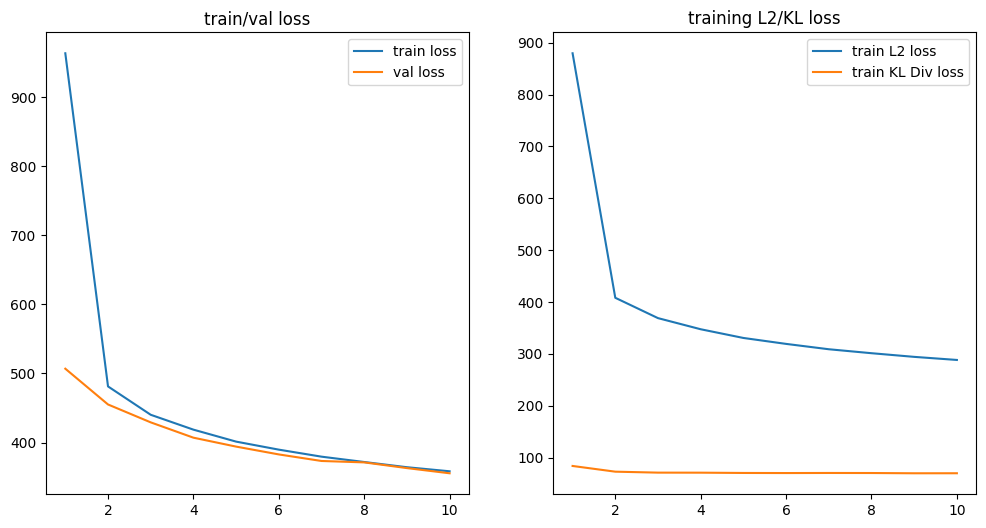

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# train/val losses plot
axs[0].plot(np.arange(1, len(train_losses) + 1, 1), train_losses, label="train loss")
axs[0].plot(np.arange(1, len(val_losses) + 1, 1), val_losses, label="val loss")
axs[0].set_title("train/val loss")
axs[0].legend(loc="best")

# kl and mse loss plot
axs[1].plot(np.arange(1, len(l2_losses) + 1, 1), l2_losses, label="train L2 loss")
axs[1].plot(
    np.arange(1, len(kldiv_losses) + 1, 1), kldiv_losses, label="train KL Div loss"
)
axs[1].set_title("training L2/KL loss")
axs[1].legend(loc="best")

In [ ]:
images = next(iter(train_loader))

torch.Size([8, 1, 256, 256])
tensor([2, 2, 4, 5, 7])


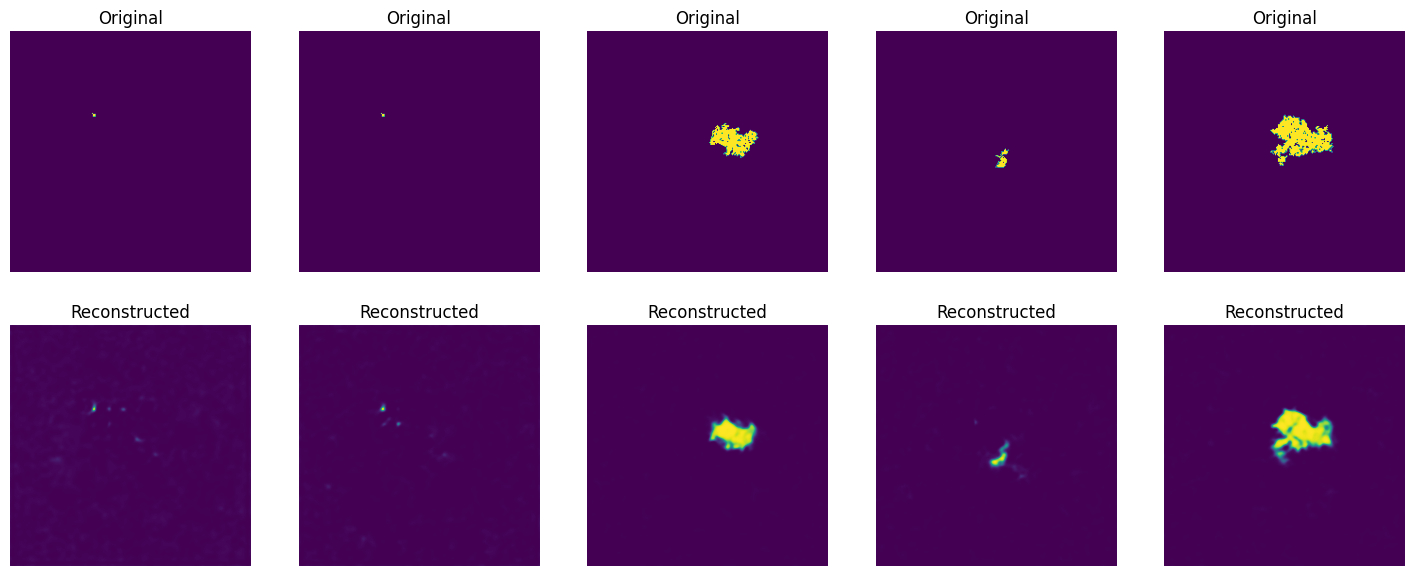

In [ ]:
# Get the first batch of images

print(images.shape)  # Print the shape of the first batch of images

# Set the model to evaluation mode
model.eval()

# Create subplots for visualization
_, ax = plt.subplots(2, 5, figsize=[18, 7])

# Select 5 random indices from the batch
np.random.seed(42)
random_indices = torch.randint(0, images.shape[0], (5,))
print(random_indices)
# random_indices = [24, 15,  8, 24,  0]
# Iterate through the selected indices and visualize original vs reconstructed images
for n, idx in enumerate(random_indices):
    image = images[idx].float().unsqueeze(0)  # Add batch dimension and move to device
    recon, _ = model(image.to(DEVICE))  # Get the reconstructed image
    # recon, _ = autoencoder(image.to(DEVICE))  # Get the reconstructed image
    ax[0, n].imshow(
        images[idx].cpu().detach().squeeze(), cmap="viridis"
    )  # Plot original image
    ax[0, n].set_title("Original")
    ax[0, n].axis("off")

    ax[1, n].imshow(
        recon.cpu().detach().squeeze(), cmap="viridis"
    )  # Plot reconstructed image
    ax[1, n].set_title("Reconstructed")
    ax[1, n].axis("off")

plt.show()

In [13]:
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=16, input_dim=256 * 256):
        """
        VAE Encoder: Encodes the input image into a latent representation.

        Args:
            latent_dim (int): Dimension of the latent space.
            input_dim (int): Dimension of the input image (flattened).
        """
        super(VAE_Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.layerMu = nn.Sequential(
            nn.Linear(128, latent_dim),
        )

        self.layerSigma = nn.Sequential(
            nn.Linear(128, latent_dim),
        )

    def forward(self, x):
        """
        Forward pass through the encoder.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            torch.Tensor: Mean of the latent space.
            torch.Tensor: Log-variance of the latent space.
        """
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        mu = self.layerMu(x)
        sigma = torch.exp(self.layerSigma(x))
        # sigma = self.layerSigma(x)
        return mu, sigma


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=16, output_dim=256 * 256):
        """
        VAE Decoder: Decodes the latent representation back to the image.

        Args:
            latent_dim (int): Dimension of the latent space.
            output_dim (int): Dimension of the output image (flattened).
        """
        super(VAE_Decoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.layer3 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            # nn.Mish(),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(512, output_dim), nn.Sigmoid()  # To output values between 0 and 1
        )

    def forward(self, z):
        """
        Forward pass through the decoder.

        Args:
            z (torch.Tensor): Latent representation.

        Returns:
            torch.Tensor: Reconstructed image.
        """
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.output_layer(z)
        z = z.view(-1, 1, 256, 256)
        return z


class VAE(nn.Module):
    def __init__(self, device="cpu"):
        """
        Variational Autoencoder (VAE) combining the encoder and decoder.

        Args:
            device (str): Device to run the model on ('cpu' or 'cuda').
        """
        super(VAE, self).__init__()
        self.device = device
        self.encoder = VAE_Encoder().to(device)
        self.decoder = VAE_Decoder().to(device)
        self.distribution = torch.distributions.Normal(0, 1)

    def sample_latent_space(self, mu, sigma):
        """
        Sample the latent space using the reparameterization trick.

        Args:
            mu (torch.Tensor): Mean of the latent space.
            sigma (torch.Tensor): Log-variance of the latent space.

        Returns:
            torch.Tensor: Sampled latent vector.
            torch.Tensor: KL divergence term.
        """
        # sigma = torch.exp(0.5 * sigma)
        # sigma = torch.exp(sigma)
        z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
        # z = mu +  sigma * self.distribution.sample(mu.shape).to(self.device)
        kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 0.5).sum()
        return z, kl_div

    def forward(self, x):
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            torch.Tensor: Reconstructed image.
            torch.Tensor: KL divergence term.
        """
        x = x.to(self.device).float()
        mu, sigma = self.encoder(x)
        z, kl_div = self.sample_latent_space(mu, sigma)
        z = self.decoder(z)
        return z, kl_div

In [58]:
# !pip install livelossplot
from livelossplot import PlotLosses

In [102]:
class VAE(nn.Module):
    def __init__(self, input_image_dims, h_dim1, h_dim2, h_dim3, latent_dims, device):
        super().__init__()

        # inputs.
        self.input_image_dims = input_image_dims
        self.c, self.h, self.w = input_image_dims
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.h_dim3 = h_dim3
        self.latent_dims = latent_dims
        self.device = device

        self.activation = nn.ReLU()
        self.distribution = torch.distributions.Normal(0, 1)

        self.encoder = nn.Sequential(
            nn.Linear(self.c * self.h * self.w, h_dim1),
            self.activation,
            nn.Linear(h_dim1, h_dim2),
            self.activation,
            nn.Linear(h_dim2, h_dim3),
            self.activation,
        )

        self._mu = nn.Linear(h_dim3, self.latent_dims)
        self._logvar = nn.Linear(h_dim3, self.latent_dims)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dims, h_dim3),
            self.activation,
            nn.Linear(h_dim3, h_dim2),
            self.activation,
            nn.Linear(h_dim2, h_dim1),
            self.activation,
            nn.Linear(h_dim1, self.c * self.h * self.w),
            nn.Sigmoid(),
        )

    def encode(self, x):
        """"""
        return self.encoder(x)

    def decode(self, x):
        """"""
        return self.decoder(x)

    def sample_latent_space(self, mu, logvar):
        """"""
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
        kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 0.5).sum()
        return z, kl_div

    def forward(self, x):
        """"""
        encoded = self.encode(x.flatten(start_dim=1))  # make sure its 1D.

        # get mu and logvar from latent space.
        mu = self._mu(encoded)
        logvar = self._logvar(encoded)

        # reparamaterise trick.
        z, kl_div = self.sample_latent_space(mu, logvar)

        decoded = self.decode(z).view(-1, self.c, self.h, self.w)

        return decoded, kl_div

In [103]:
autoencoder = VAE(
    input_image_dims=(1, 256, 256),
    h_dim1=512,
    h_dim2=256,
    h_dim3=128,
    latent_dims=16,
    device=DEVICE,
).to(DEVICE)

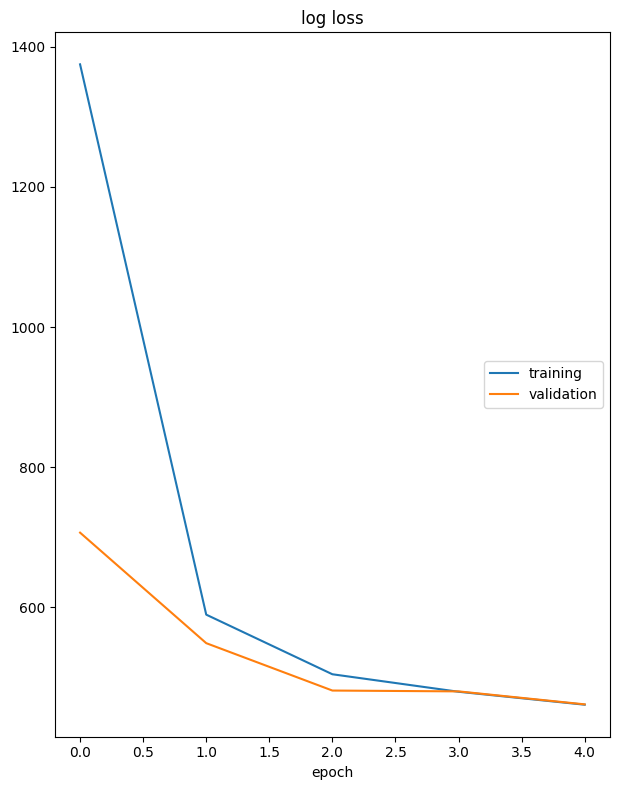

log loss
	training         	 (min:  461.218, max: 1374.885, cur:  461.218)
	validation       	 (min:  461.716, max:  706.717, cur:  461.716)
Epoch 5, Training Loss: 461.2181, Validation Loss: 461.7162


In [104]:
opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
liveloss = PlotLosses()

train_losses = []
val_losses = []

device = DEVICE

n_epochs = 5

for epoch in range(n_epochs):
    logs = {}

    # Training phase
    autoencoder.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device).float()
        opt.zero_grad()
        x_hat, KL = autoencoder(batch)
        loss = ((batch - x_hat) ** 2).sum() + KL
        loss.backward()
        train_loss += loss.item()
        opt.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    logs["log loss"] = avg_train_loss
    train_losses.append(avg_train_loss)

    # Validation phase
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device).float()
            x_hat, KL = autoencoder(batch)
            loss = ((batch - x_hat) ** 2).sum() + KL
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    logs["val_log loss"] = avg_val_loss
    val_losses.append(avg_val_loss)

    liveloss.update(logs)
    liveloss.send()

    print(
        f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )

In [ ]:
torch.save(
    {
        "model_state_dict": autoencoder.state_dict(),
    },
    f"model_test.pt",
)

In [45]:
def load_model(model_obj, model_path, device):
    # model_obj.load_state_dict(torch.load(model_path))
    model_obj.load_state_dict(
        torch.load(model_path, map_location=torch.device(device))["model_state_dict"]
    )
    model_obj.to(device)
    model_obj.eval()
    return model_obj

In [14]:
autoencoder = VAE(
    input_image_dims=(1, 256, 256),
    h_dim1=512,
    h_dim2=256,
    h_dim3=128,
    latent_dims=16,
    device=DEVICE,
).to(DEVICE)

In [47]:
model_t = load_model(model_obj=autoencoder, model_path="model_test.pt", device=DEVICE)
model_t

VAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (_mu): Linear(in_features=128, out_features=16, bias=True)
  (_logvar): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=65536, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
A = Decompressor()

In [28]:
from abc import abstractmethod
import joblib
import torch


class Decompressor:
    def __init__(self):
        self.model = None

    @abstractmethod
    def load_model(self, model_path):
        pass

    @abstractmethod
    def encode(self, x):
        pass

    @abstractmethod
    def decode(self, x):
        pass


class VAEDecompressor(Decompressor):
    def __init__(self, model_path, model_obj, device):
        super().__init__()

        self.model_path = model_path
        self.model_obj = model_obj
        self.device = device

        self.model = self.load_model(
            model_path=model_path, model_obj=self.model_obj, device=self.device
        )

    def load_model(self, model_path, model_obj, device):
        try:
            model_state = torch.load(model_path, map_location=torch.device(device))
            model_obj.load_state_dict(model_state["model_state_dict"])
            model_obj.to(device)
            model_obj.eval()

            return model_obj

        except KeyError:
            raise ValueError("Model state dict key not found in the loaded model file")

    def encode(self, x):
        return self.model.encode(x.to(self.device))

    def decode(self, x):
        return self.model.decode(x.to(self.device))


class PCADecompressor(Decompressor):
    # non CPU/GPU --> dont need device.
    def __init__(self, model_path):
        super().__init__()

        self.model_path = model_path
        self.model = self.load_model(model_path)

    def load_model(self, model_path):
        model_obj = joblib.load(model_path)
        return model_obj

    def encode(self, x):
        return self.model.transform(x)

    def decode(self, x):
        return self.model.inverse_transform(x)

In [29]:
autoencoder = VAE(
    input_image_dims=(1, 256, 256),
    h_dim1=512,
    h_dim2=256,
    h_dim3=128,
    latent_dims=16,
    device=DEVICE,
).to(DEVICE)

vae_test = VAEDecompressor(
    model_obj=autoencoder, model_path="model_test.pt", device=DEVICE
)
A = vae_test.encode(x=torch.randn(1, 256 * 256))
B = vae_test.decode(x=torch.randn(1, 16))

(torch.Size([1, 128]), torch.Size([1, 65536]))

In [ ]:
pca_test = PCADecompressor(model_path="pca_1_model.pkl")
A = pca_test.encode(x=torch.randn(1, 256 * 256))
B = pca_test.decode(x=torch.randn(1, 1))

A.shape, B.shape

In [30]:
from sklearn.decomposition import PCA

_d = torch.randn(10, 256 * 256)
pca = PCA(n_components=1)
pca.fit(_d)

import pickle

# saving the PCA object.
with open(f"pca_{pca.n_components_}_model.pkl", "wb") as file:
    pickle.dump(pca, file)

In [31]:
pca_test = PCADecompressor(model_path="pca_1_model.pkl")
A = pca_test.encode(x=torch.randn(1, 256 * 256))
B = pca_test.decode(x=torch.randn(1, 1))

A.shape, B.shape

((1, 1), (1, 65536))

In [32]:
vae_test.decode(x=torch.randn(1, 16))

tensor([[0.0019, 0.0003, 0.0004,  ..., 0.0004, 0.0009, 0.0005]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
# log loss
# 	training         	 (min:  304.551, max:  950.183, cur:  304.551)
# 	validation       	 (min:  279.946, max:  586.310, cur:  279.946)
# Epoch 15, Training Loss: 304.5506, Validation Loss: 279.9463

In [ ]:
# --> stability
# log loss
# 	training         	 (min:  288.797, max:  942.912, cur:  288.797)
# 	validation       	 (min:  268.022, max:  576.556, cur:  286.110)
# Epoch 15, Training Loss: 288.7966, Validation Loss: 286.1100

In [22]:
batch_size

8


| Model Arch | Train Loss | Val Loss | Test Loss | Recons | Epochs | Comments |
|------------|------------|----------|-----------|--------|--------|----------|
| Model 1: Model 1: baseline (512->256->128->16) no stability : Relu() : batchsize: 32 : loss = mse + KL     | 0.025      | 0.030    | 0.028     | Recons look good.    | **15**    | ...  |
| Model 2: (added stability): (512->256->128-->16) w/ stability : Relu() : batchsize: 32 : loss = mse + KL     | 288.797      | 286.110      | 0.022     | Recons slightly better at the edges than Model 1.  | **15**     | Keep stability.  |


# KL warm up
# scheduler in training
# VGG loss  <-- for realistic images.
# +20 epoch "juicer"
# try BCE loss?

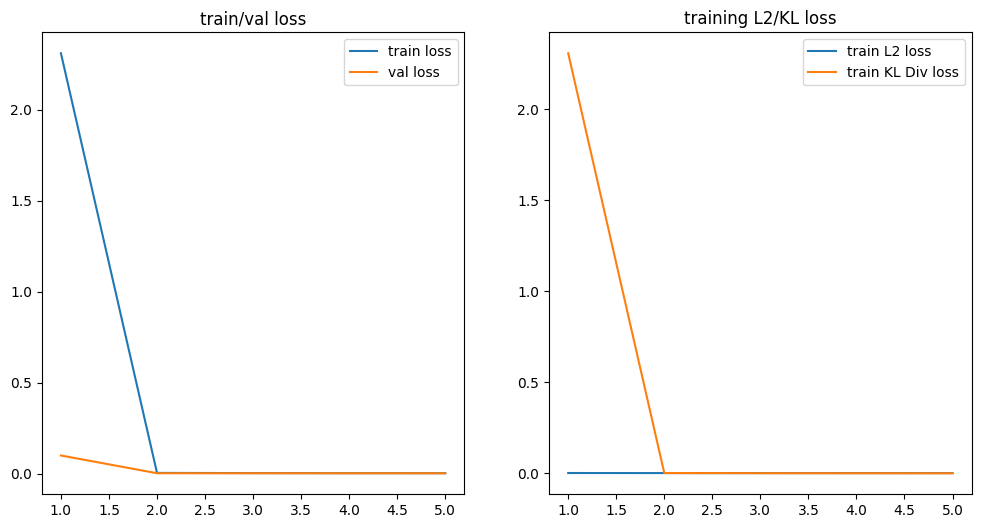

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# train/val losses plot
axs[0].plot(np.arange(1, len(train_losses) + 1, 1), train_losses, label="train loss")
axs[0].plot(np.arange(1, len(val_losses) + 1, 1), val_losses, label="val loss")
axs[0].set_title("train/val loss")
axs[0].legend(loc="best")

# kl and mse loss plot
axs[1].plot(np.arange(1, len(l2_losses) + 1, 1), l2_losses, label="train L2 loss")
axs[1].plot(
    np.arange(1, len(kldiv_losses) + 1, 1), kldiv_losses, label="train KL Div loss"
)
axs[1].set_title("training L2/KL loss")
axs[1].legend(loc="best")

random idxs = tensor([6, 0, 5, 0, 6])


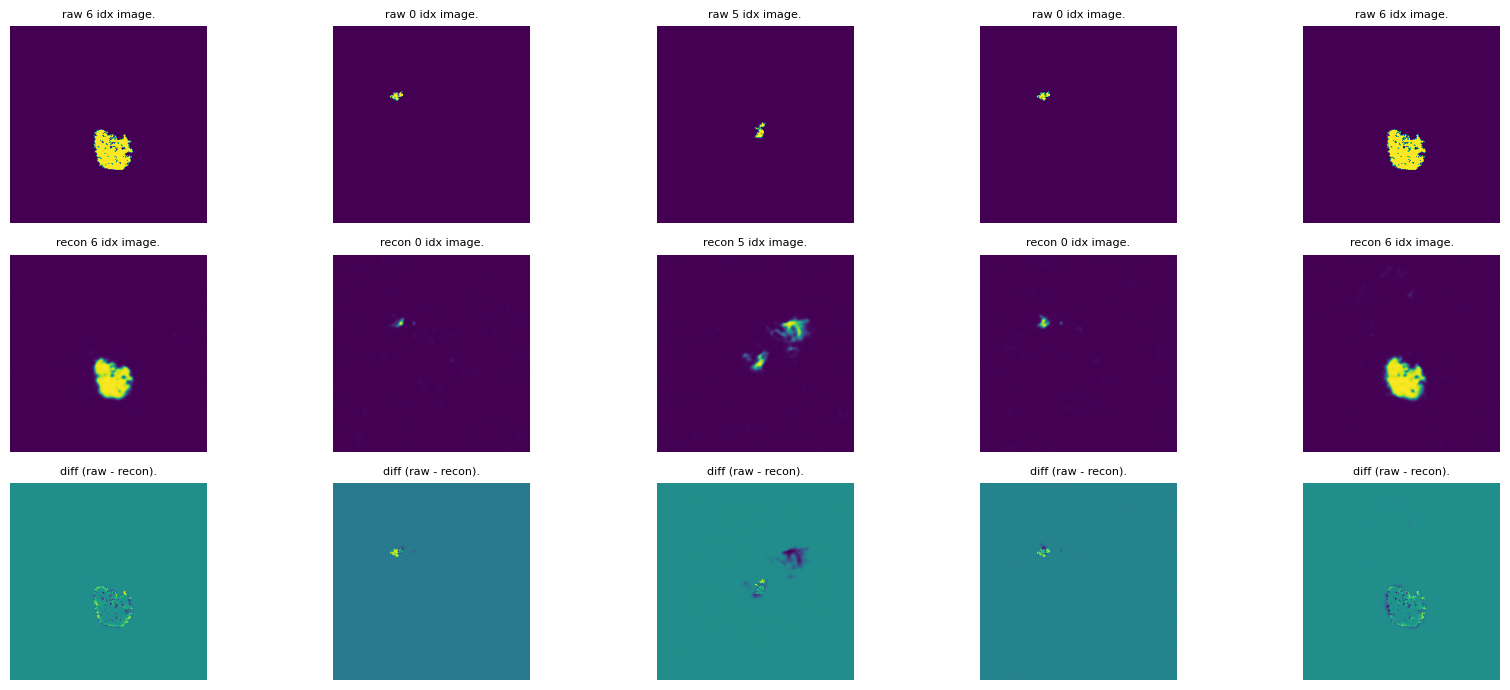

In [72]:
plot_generated_images(model=model, data_loader=train_loader, num_images=5)

tensor([7, 5, 0, 2, 2])


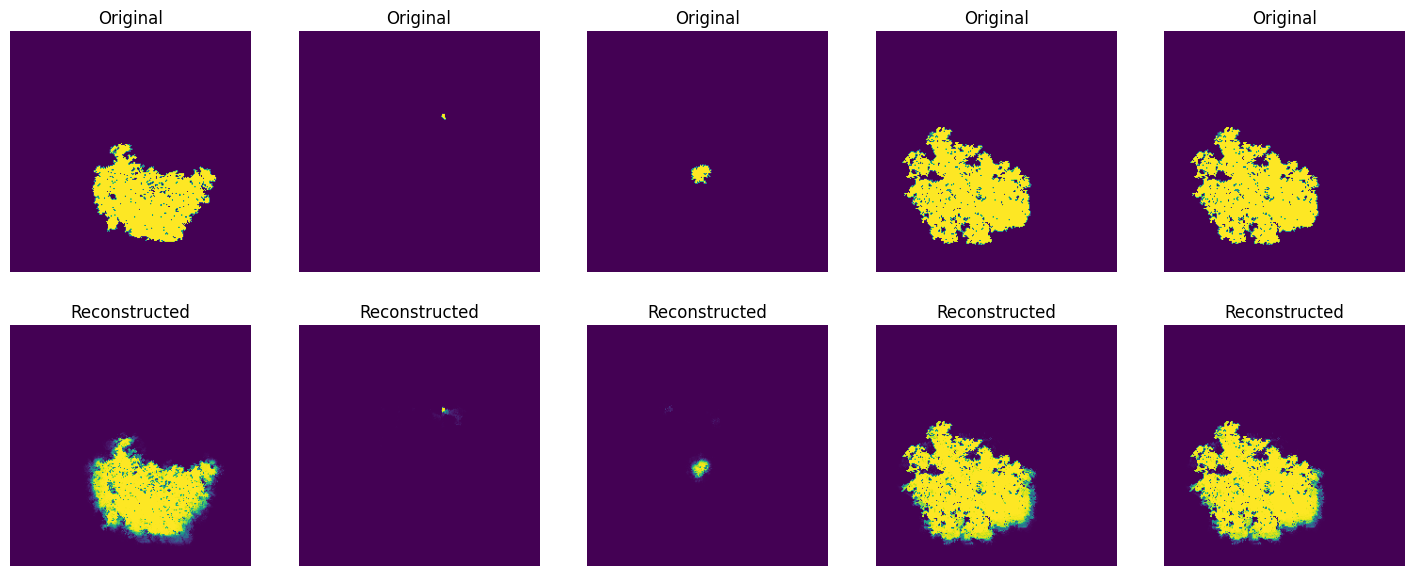

In [26]:
# Set the model to evaluation mode
autoencoder.eval()

# Create subplots for visualization
_, ax = plt.subplots(2, 5, figsize=[18, 7])

# Select 5 random indices from the batch
random_indices = torch.randint(0, images.shape[0], (5,))
# random_indices = [24, 15,  8, 24,  0]
print(random_indices)

# Iterate through the selected indices and visualize original vs reconstructed images
for n, idx in enumerate(random_indices):
    image = images[idx].float().unsqueeze(0)  # Add batch dimension and move to device
    # recon, _, _ = model(image.to(DEVICE))  # Get the reconstructed image
    recon, _ = autoencoder(image.to(DEVICE))  # Get the reconstructed image
    ax[0, n].imshow(
        images[idx].cpu().detach().squeeze(), cmap="viridis"
    )  # Plot original image
    ax[0, n].set_title("Original")
    ax[0, n].axis("off")

    ax[1, n].imshow(
        recon.cpu().detach().squeeze(), cmap="viridis"
    )  # Plot reconstructed image
    ax[1, n].set_title("Reconstructed")
    ax[1, n].axis("off")

plt.show()

In [31]:
def test_data_metrics(model, criterion, data_loader, device):
    total_error = 0
    with torch.no_grad():
        for X_test in data_loader:
            X_test = X_test.float().to(DEVICE)
            recon, _ = model(X_test)
            error = criterion(X_test_recon, X_test)
            total_error += error

    return (total_error / len(data_loader.dataset)).item()

In [34]:
criterion = nn.MSELoss(reduction="sum")
test_mse = test_data_metrics(
    autoencoder, criterion, data_loader=test_loader, device=DEVICE
)
test_mse

590.1953125

torch.Size([32, 1, 256, 256])


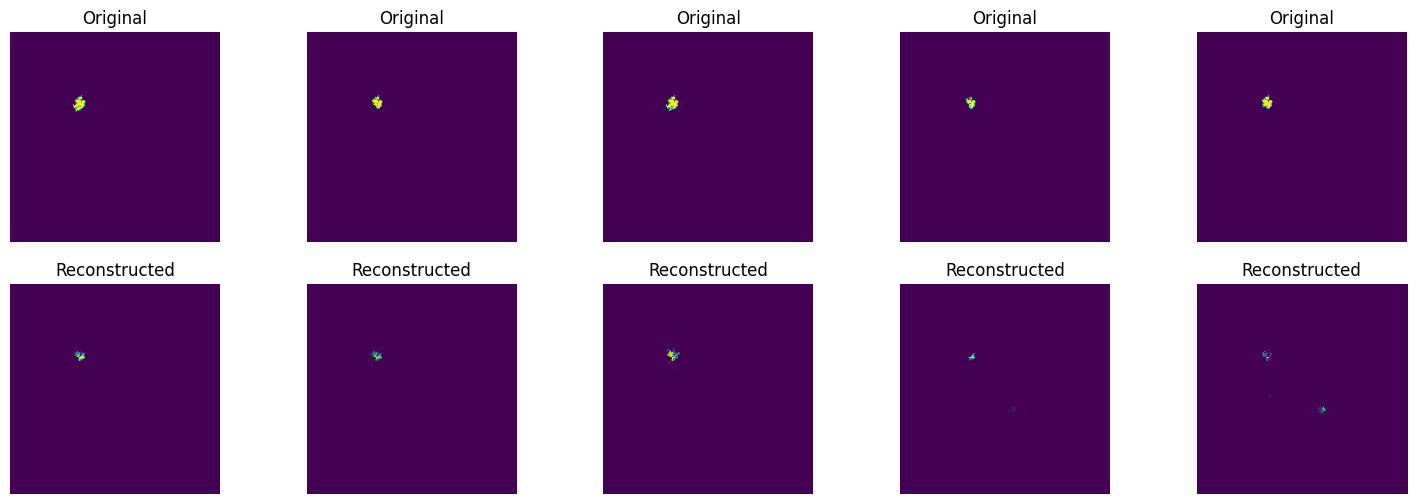

In [37]:
images = next(iter(test_loader))  # Get the first batch of images
print(images.shape)  # Print the shape of the first batch of images

# Set the model to evaluation mode
model.eval()

# Create subplots for visualization
_, ax = plt.subplots(2, 5, figsize=[18.5, 6])

# Select 5 random indices from the batch
random_indices = torch.randint(0, images.shape[0], (5,))

# Iterate through the selected indices and visualize original vs reconstructed images
for n, idx in enumerate(random_indices):
    image = images[idx].float().unsqueeze(0)  # Add batch dimension and move to device
    # recon, _, _ = model(image.to(DEVICE))  # Get the reconstructed image
    recon, _ = autoencoder(image.to(DEVICE))  # Get the reconstructed image
    ax[0, n].imshow(images[idx].cpu().squeeze(), cmap="viridis")  # Plot original image
    ax[0, n].set_title("Original")
    ax[0, n].axis("off")

    ax[1, n].imshow(
        recon.cpu().detach().squeeze(), cmap="viridis"
    )  # Plot reconstructed image
    ax[1, n].set_title("Reconstructed")
    ax[1, n].axis("off")

plt.show()

In [41]:
def generate_images(model, num_samples=100, latent_dim=64, unnorm: bool = True):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(DEVICE)
        # samples = model.decode(z).cpu()
        samples = model.decoder(z).cpu()

        # # Postprocess samples if necessary (e.g., un-normalize)
        # if unnorm:
        #     samples = (samples + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
        return samples

In [49]:
generated_images = generate_images(
    model=autoencoder, num_samples=100, latent_dim=16, unnorm=False
)

In [1]:
generated_images = generate_images(
    model=autoencoder, num_samples=100, latent_dim=16, unnorm=False
)

# Visualizing 300 generated images
import matplotlib.pyplot as plt

nrows = 10
ncols = 10

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].imshow(np.round(generated_images[i * ncols + j].squeeze()))
        ax[i, j].axis("off")
plt.tight_layout()
plt.show()

NameError: name 'generate_images' is not defined

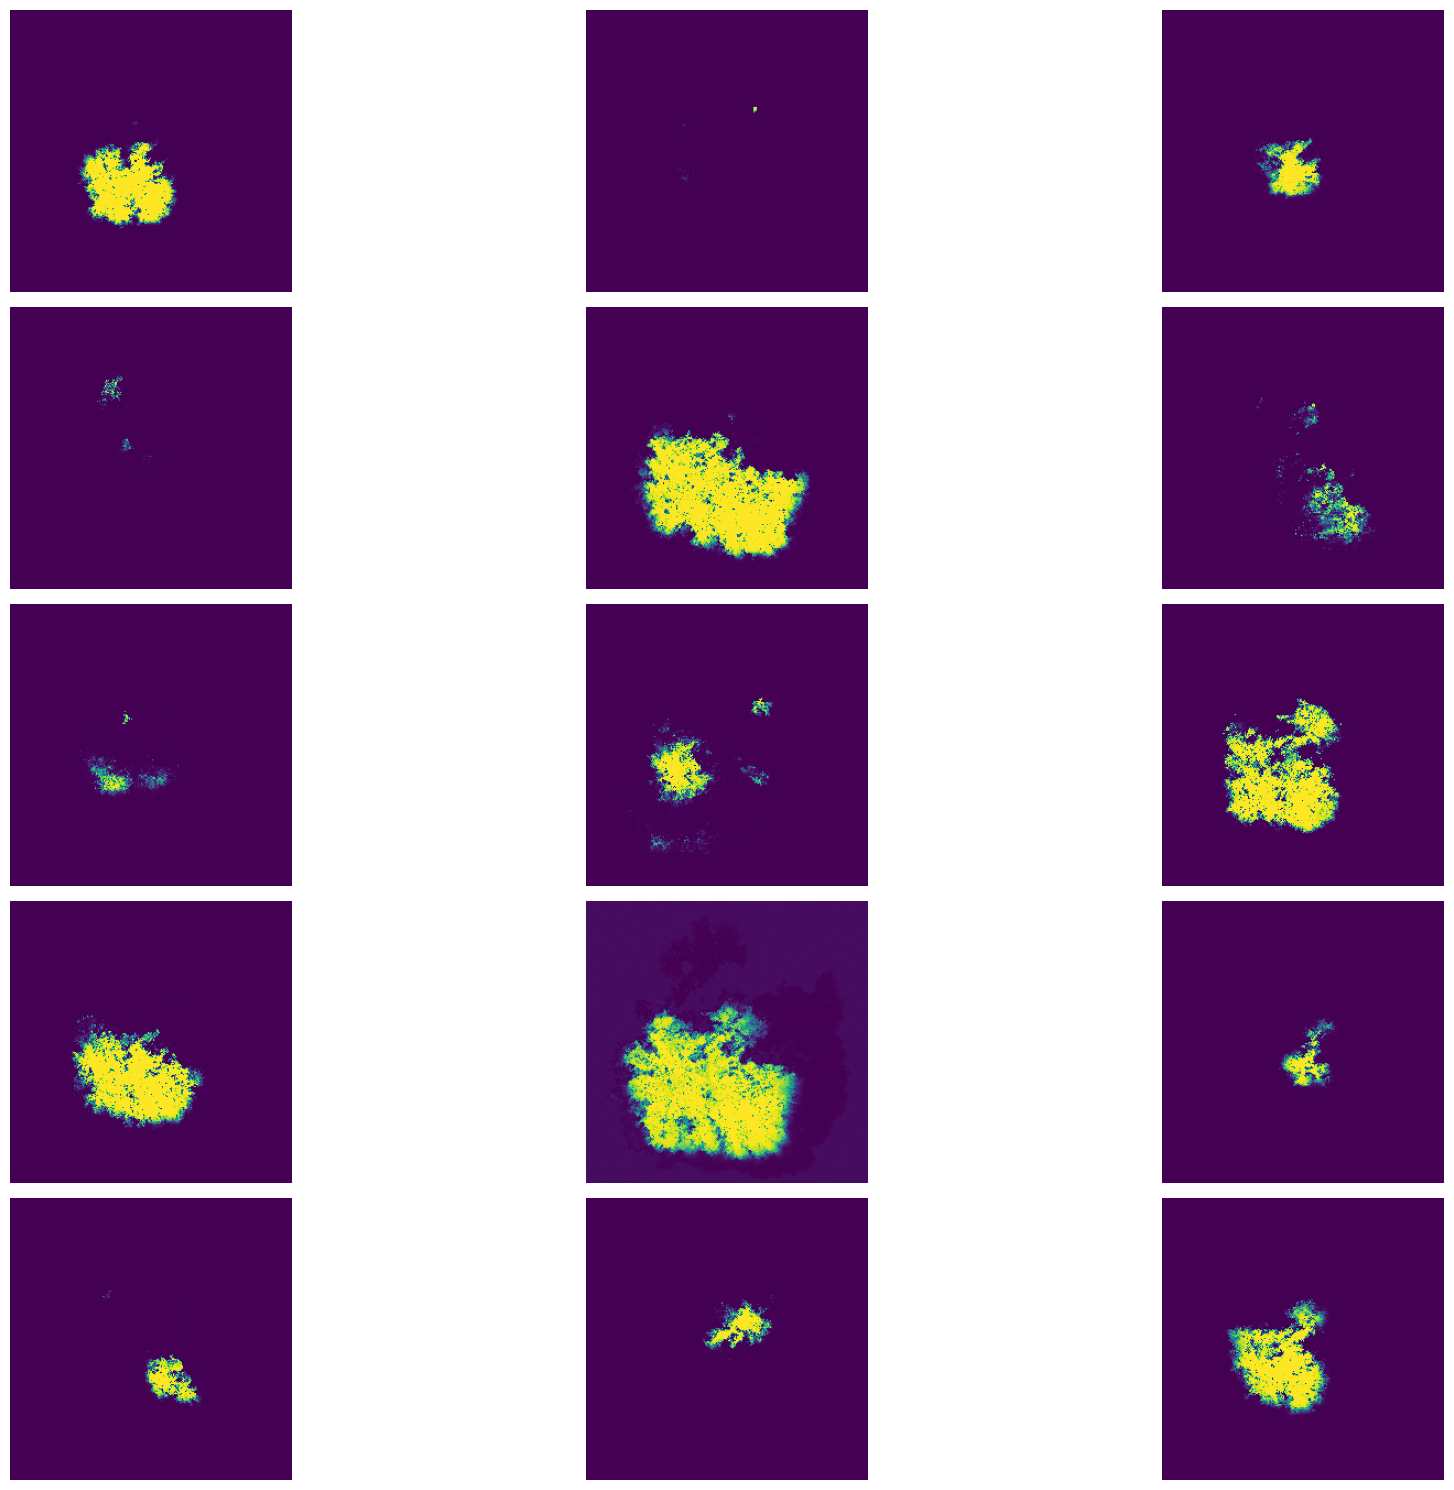

In [45]:
# Visualizing 300 generated images
import matplotlib.pyplot as plt

nrows = 5
ncols = 3

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].imshow(generated_images[i * ncols + j].squeeze())
        ax[i, j].axis("off")
plt.tight_layout()
plt.show()